In [1]:
import sys

sys.path.append("..")
from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer_nu_flows_neutrino_only/"
    MODEL_DIR = "../models/regression_transformer/"
else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"


CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)
PREDICTIONS_DIR = os.path.join(
    load_config.data_dir,
    "RegressionTransformer_nu_flows_neutrino_only",
    "odd_predictions/",
)

data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], event_numbers="odd", max_events=1_000_000
)
X, y = DataProcessor.get_data()
del DataProcessor

2026-01-29 16:34:17.650316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769700857.676509 2084338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769700857.684430 2084338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769700857.704932 2084338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769700857.704958 2084338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769700857.704960 2084338 computation_placer.cc:177] computation placer alr

## Load Model and Setup Evaluator

In [2]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
transformer = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer $\nu$"
)
MODEL_DIR = "../models/regression_transformer/"
transformer.load_model(f"{MODEL_DIR}/model.keras")

prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner,transformer], X, y#, load_directory=PREDICTIONS_DIR
)

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

I0000 00:00:1769700957.139410 2084338 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8051 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from ../models/regression_transformer//model.keras
Training history loaded from ../models/regression_transformer//model_history.npz


I0000 00:00:1769700962.103368 2086715 service.cc:152] XLA service 0x7f3214010740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769700962.103398 2086715 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2026-01-29 16:36:02.201025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1769700962.821887 2086715 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1769700966.091672 2086715 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


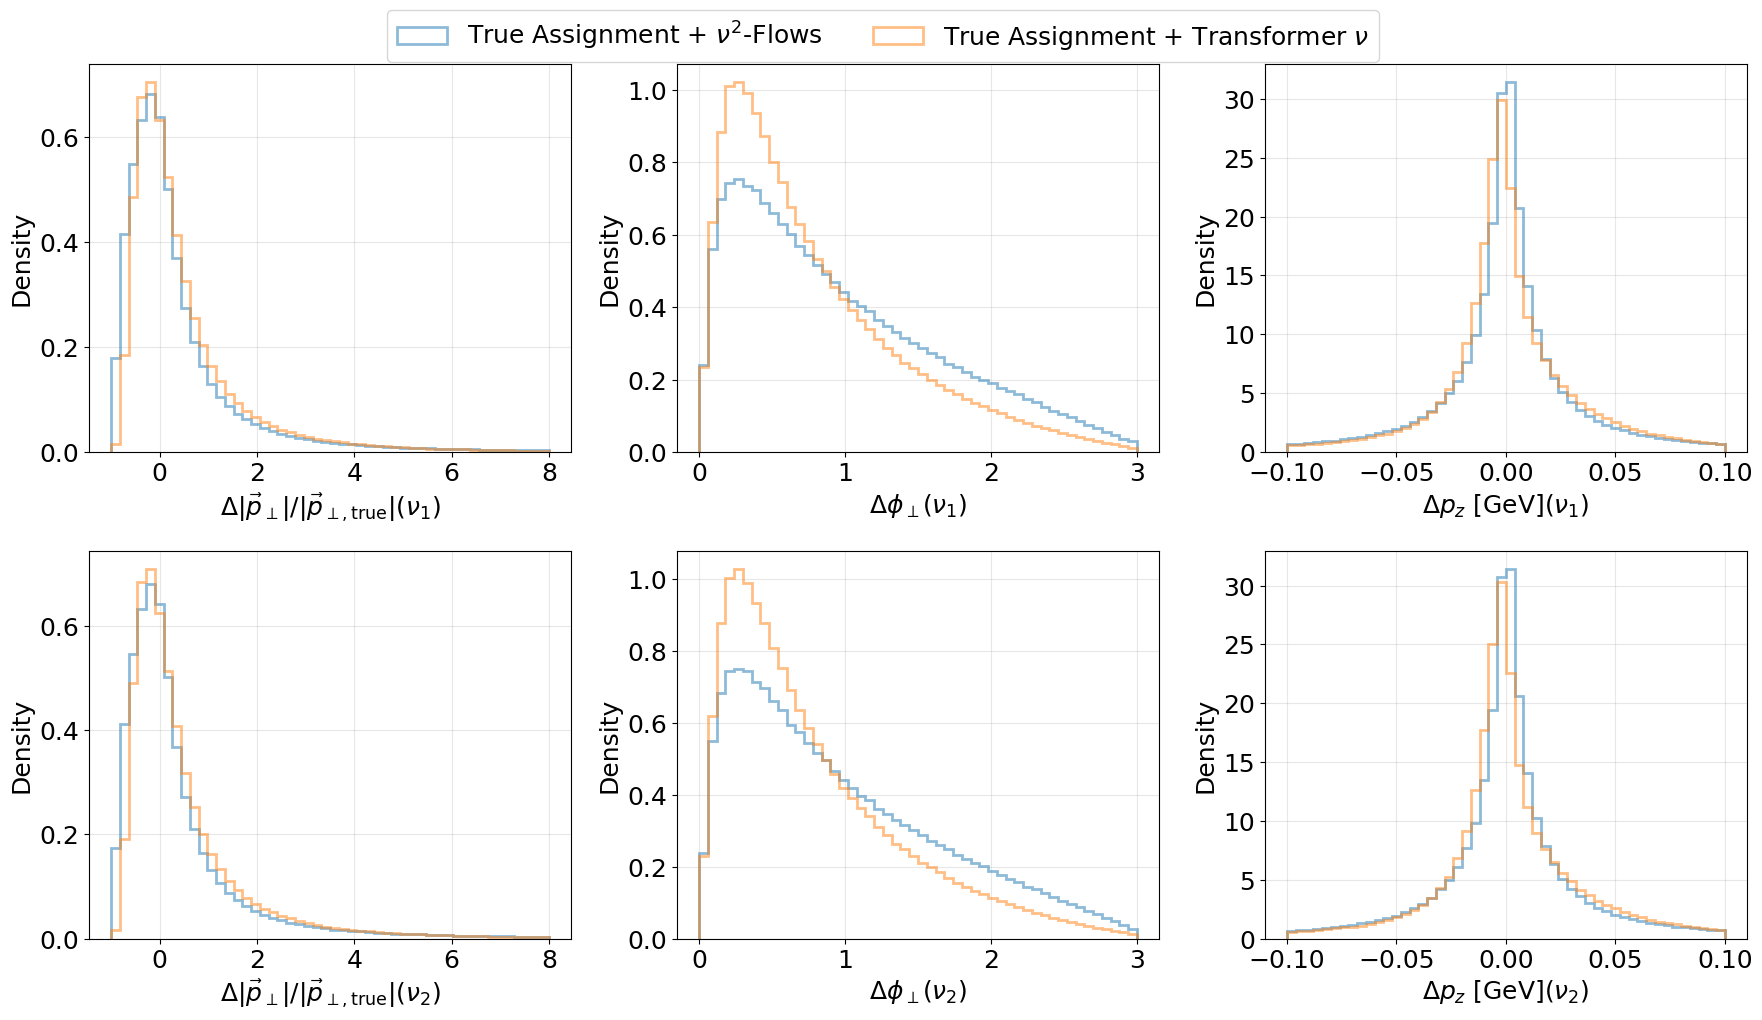

In [3]:
fig, ax = evaluator.plot_relative_neutrino_deviations(
    bins=50, coords="spherical_lepton_fixed", xlims=[(-1,8),(0,3),(-100/1e3,100/1e3)]
)
fig.savefig(
    f"{PLOTS_DIR}/neutrino_reconstruction_comparison_spherical.pdf", bbox_inches="tight"
)

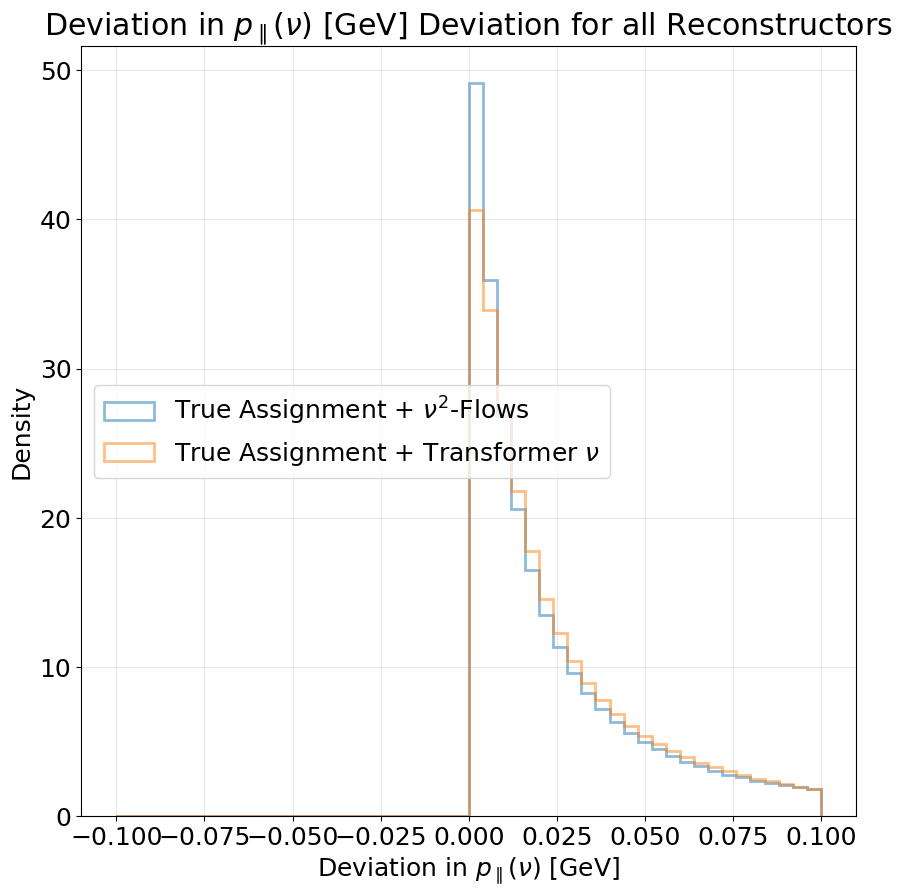

In [4]:
fig, ax = evaluator.plot_variable_deviation("parallel_component_nu", bins=50,xlims=(-100/1e3,100/1e3))
ax.legend(loc="center left")
fig.savefig(os.path.join(PLOTS_DIR, "nu_parallel_component_deviation.pdf"))

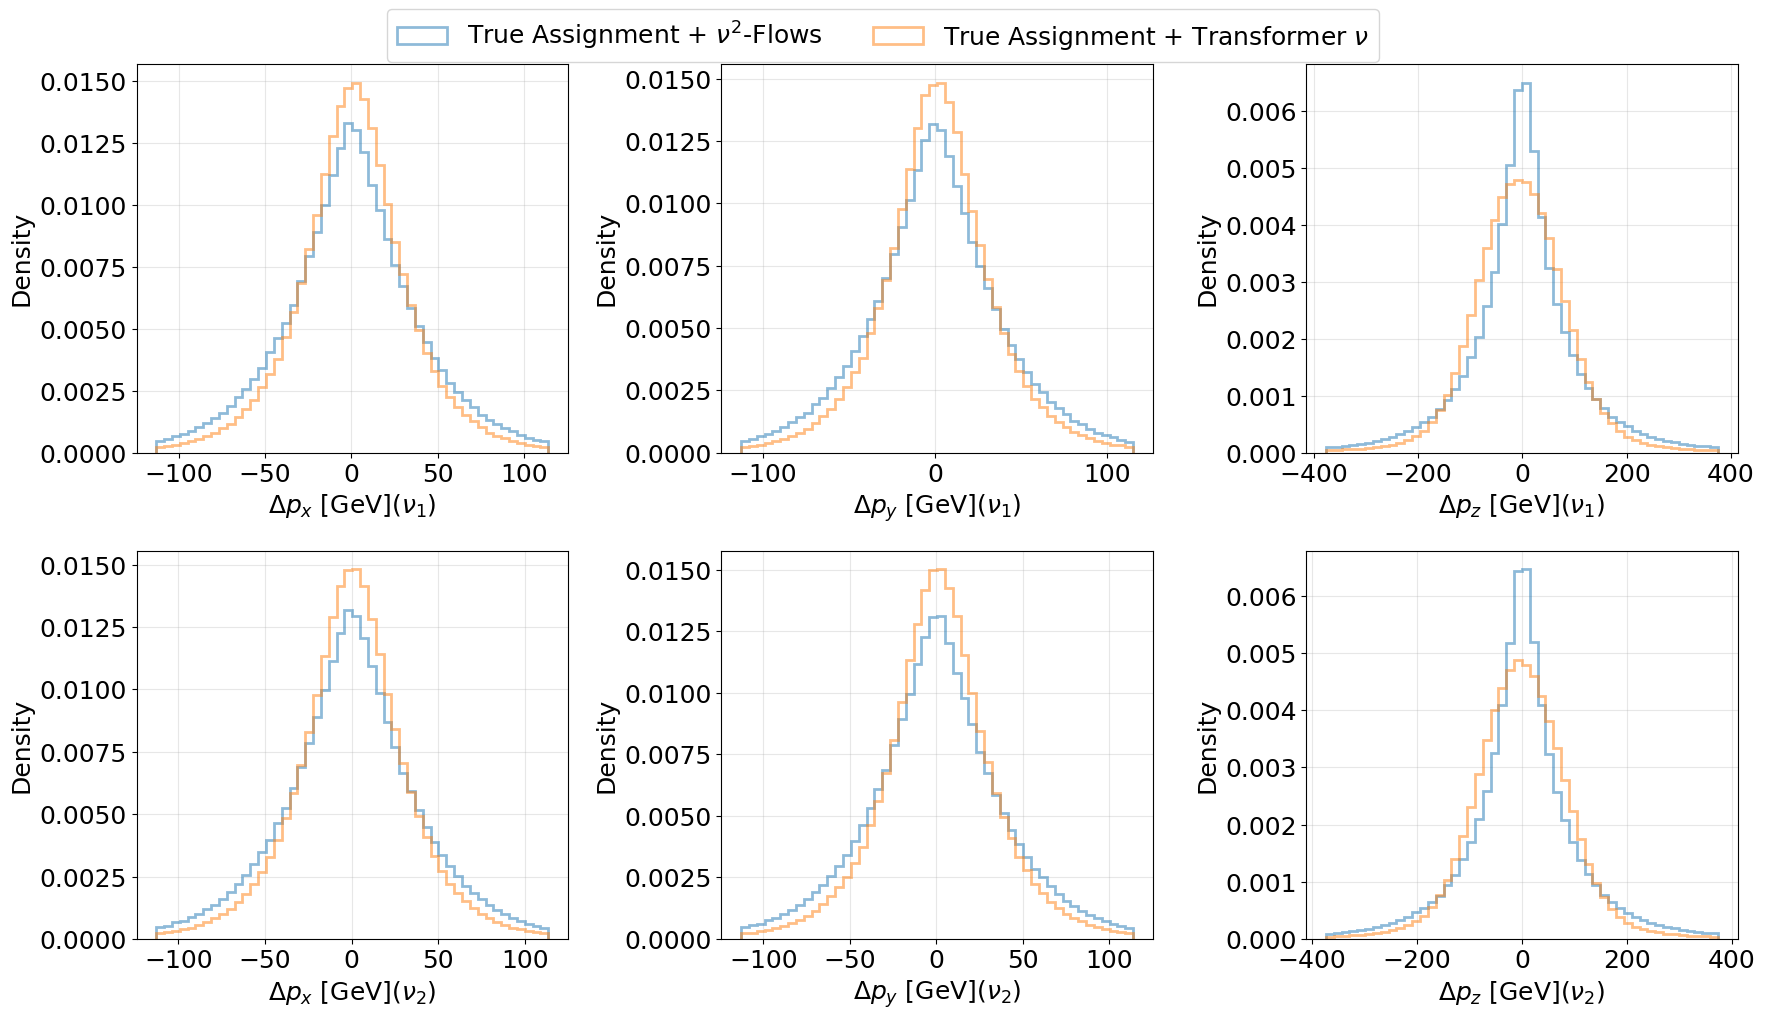

In [7]:
fig, ax = evaluator.plot_relative_neutrino_deviations(bins=50, coords="cartesian")
fig.savefig(f"{PLOTS_DIR}/neutrino_reconstruction_comparison.pdf", bbox_inches="tight")

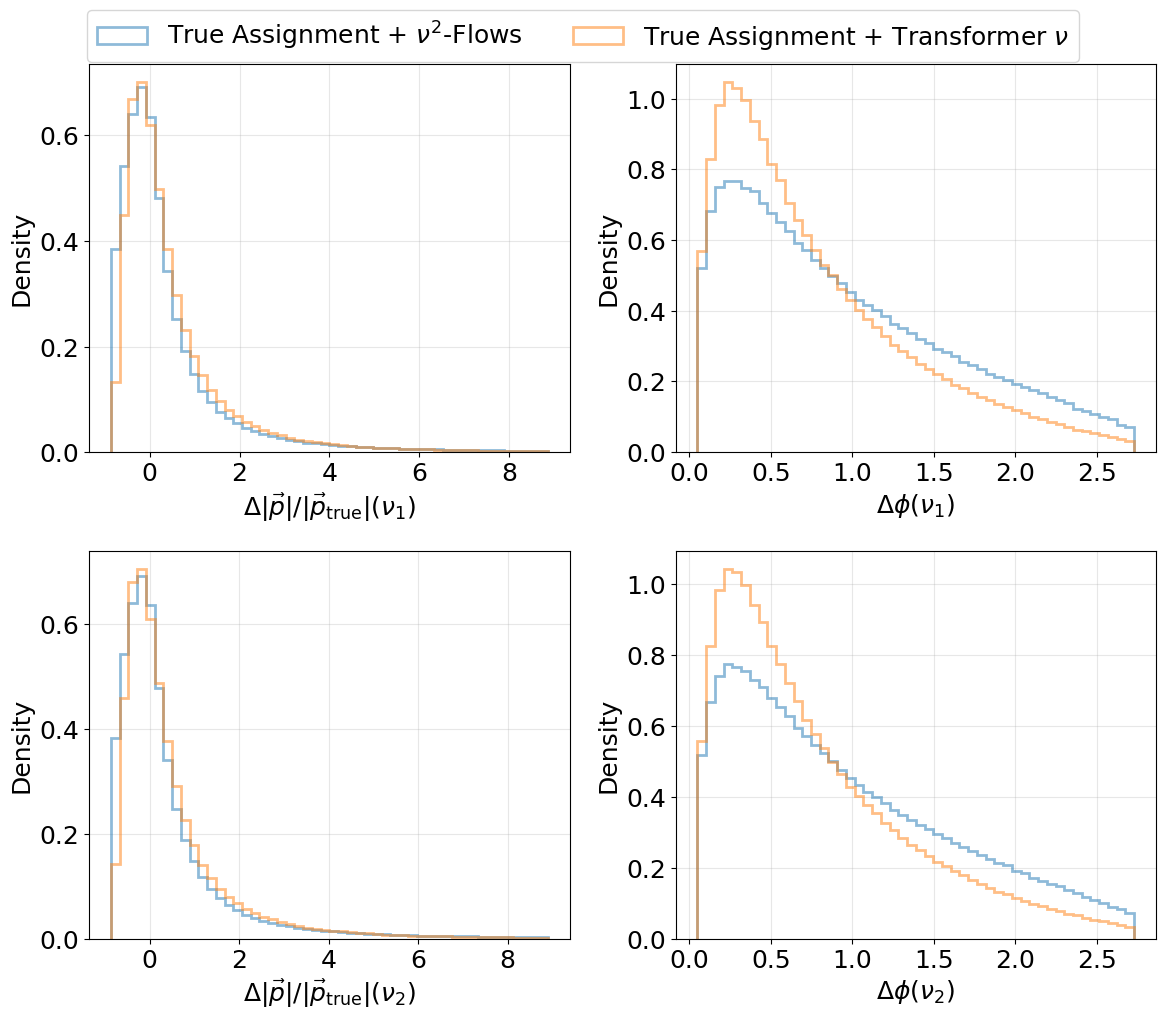

In [8]:
fig, ax = evaluator.plot_relative_neutrino_deviations(bins=50, coords="spherical")
fig.savefig(f"{PLOTS_DIR}/neutrino_reconstruction_comparison_spherical.pdf", bbox_inches="tight")